# Centrifugation Model

This notebook details the development, discovery, and implementation of a centrifugation model. The model explores how the "Ratios of Ratios" within a distribution are affected over time, as observed in centrifugation processes.

# Background Theory

The theoretical foundation is straightforward, based on the sedimentation theory outlined by Mohr, H., & Völkl, A. (2017) in "Ultracentrifugation."

The sedimentation speed is defined as:

$$
\text{𝜈} = \frac{2r_s^2 (\rho_s - \rho_l)}{9\eta} F
$$

Where:

$$
F = \omega^2 r
$$

## Implementation

### Initial State

- **Uniform Distribution**: Each concentration of particles is assumed to be uniformly distributed in 1D space.
- **Parameter Setup**: Key parameters such as centrifuge speed, duration, arm length, particle and fluid density, and fluid viscosity are established.

### Sedimentation Rates

- **Determining Sedimentation Velocity**: Based on the parameters set, the sedimentation velocity is calculated for each particle size.

### Pellets or Supernatant

- **Classification**: Based on sedimentation velocities and the duration of centrifugation, a proportion of particles will reach the bottom of the container, forming pellets. Particles that do not reach the bottom will remain in the supernatant.

### Ratio of Ratios

- **New Concentration Distribution**: A new concentration distribution for each particle size is determined by reducing the initial concentration of particles by the ratio of particles that form pellets.
- **Centrifugation Cycles**: This reduction process, where the ratio is adjusted by another ratio over centrifugation cycles, is a key focus of the model.

---

Mohr, H., & Völkl, A. (2017). Ultracentrifugation. In eLS, John Wiley & Sons, Ltd (Ed.) (pp. 1-9).

---

In [189]:
# Loading in the Libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import gamma

# Allows for the hot reloading of modules
%load_ext autoreload
%autoreload 2

# Loading in the Simulation Objects
from src.Centrifugation import *
from src.DataLoader import load_data_from_txt, normalize_data, load_data_from_excel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# Standard Centrifugation parms
time = 10 # (min)
rpm = 4000
arm_length = 10 * 1e-2 # length of centrifuge 10cm  (m)
length = 1 * 1e-2 # tube length 1cm (m)

# Liquid parms
liquid_density = 997 # water (kg/m^2)
liquid_viscosity = 1 # water (mPa.s)

# Particle parms
particle_density = 2330 # silicon (kg.m^2)

First, lets get just the composition change of a single particle size by reducing the amount of supernantant particle as the particles become pallet. 


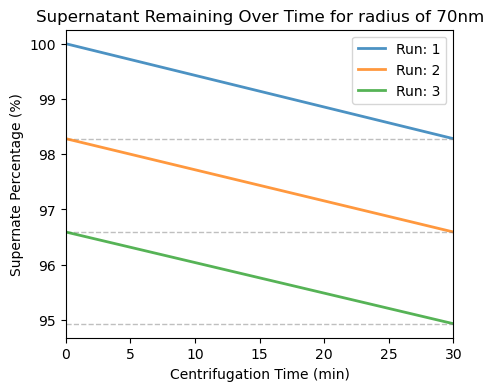

In [206]:
# How does mutiple runs look for a single size particle?
size = 70 * 1e-9
rpm = 1000
runs = 3

prob = 1

fig, ax = plt.subplots(figsize=(5,4))
for run in range(runs):
    time = np.linspace(0,30,100)
    prob_remaining = cal_remaining_percent(size, prob, time,
                                            particle_density, liquid_density, liquid_viscosity,
                                            rpm, arm_length, length)
    prob = prob_remaining[-1]
    ax.plot(time, prob_remaining * 1e2, label=f"Run: {run +1}", alpha = 0.8, linewidth=2) 

    # Add a gray dotted line at y=prob
    ax.axhline(y=prob * 1e2, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# ax.set_ylim([0,100])
ax.set_xlim([0,time[-1]])

ax.set_xlabel("Centrifugation Time (min)")
ax.set_ylabel("Supernate Percentage (%)")
ax.set_title(f'Supernatant Remaining Over Time for radius of {size * 1e9:.0f}nm')
ax.legend()


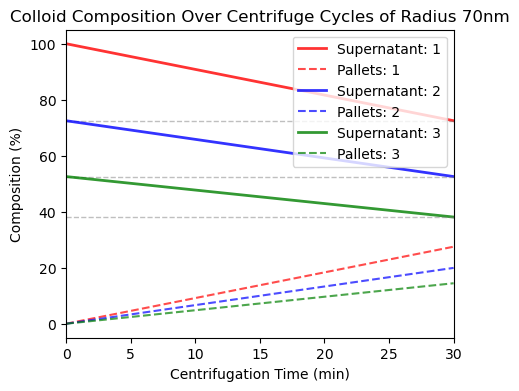

In [214]:
# Pallets and supernatants
size = 70 * 1e-9
rpm = 4000
runs = 3 

prob = 1

# Define a color cycle for different runs
colors = ['red', 'blue', 'green']

fig, ax = plt.subplots(figsize=(5,4))
for run in range(runs):
    time = np.linspace(0,30,100)
    supernate, pallets = cal_supernate_and_pallets(size, prob, time,
                                            particle_density, liquid_density, liquid_viscosity,
                                            rpm, arm_length, length)
    prob = supernate[-1]
    ax.plot(time, supernate * 1e2, label=f"Supernatant: {run +1}", alpha = 0.8, linewidth=2, color=colors[run]) 
    ax.plot(time, pallets * 1e2, label=f"Pallets: {run + 1}", alpha=0.7, linestyle='--', color=colors[run])

    # Add a gray dotted line at y=prob
    ax.axhline(y=prob * 1e2, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# ax.set_ylim([0,100])
ax.set_xlim([0,time[-1]])

ax.set_xlabel("Centrifugation Time (min)")
ax.set_ylabel("Composition (%)")
ax.set_title(f'Colloid Composition Over Centrifuge Cycles of Radius {size * 1e9:.0f}nm')
ax.legend()


The plot above shows the change in composition of particles of a single size (70 nm) over the course of several centrifugation cycles. As we can see, the amount of particles that become part of the pellet increases with each centrifugation run, while the amount remaining in the supernatant decreases.

It's important to note that the percentages displayed are relative to the total initial composition of that specific particle size. This helps to illustrate how the proportion of particles changes as they are separated into supernatant and pellet fractions through repeated centrifugation.

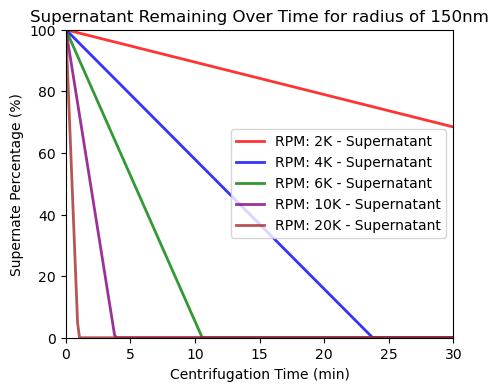

In [44]:
# How does speed effect the change over time
count = 1000
size = 150 * 1e-9
rpm = np.array([2000, 4000, 6000, 10000, 20000])
j = 0

fig, ax = plt.subplots(figsize=(5,4))

colors = ['red', 'blue', 'green', 'purple', 'brown']

for speed in rpm:
    prob = 1
    time = np.linspace(0,30,200)
    prob, pallets = cal_supernate_and_pallets(size, prob, time,
                                          particle_density, liquid_density, liquid_viscosity,
                                         speed, arm_length, length)
    
    
#     ax.plot(time, remaining_percent * 1e2, label=f"RPM: {speed * 1e-3:.0f}K", alpha = 0.8, linewidth=2)
    ax.plot(time, prob * 1e2, label=f"RPM: {speed * 1e-3:.0f}K - Supernatant", alpha = 0.8, linewidth=2, color=colors[j]) 
#     ax.plot(time, pallets * 1e2, label=f"RPM: {speed * 1e-3:.0f}K - Pallets", alpha=0.7, linestyle='--', color=colors[j])
    j += 1
    

ax.set_ylim([0,100])
ax.set_xlim([0,time[-1]])

ax.set_xlabel("Centrifugation Time (min)")
ax.set_ylabel("Supernate Percentage (%)")
ax.set_title(f'Supernatant Remaining Over Time for radius of {size * 1e9:.0f}nm')
ax.legend()


The plot above illustrates how the rate of sedimentation (indicated by the gradient) for particles of a specific size (150 nm) depends on the centrifugation speed (RPM). As the RPM increases, the rate at which particles sediment and leave the supernatant accelerates, leading to a steeper decline in the supernatant percentage over time. This demonstrates the strong influence of centrifugation speed on the efficiency of particle separation.

---

### Testing the Behavior of the Model - Uniform Size Distribution

Before expanding the investigation to explore how the model performs on a complete size distribution, let's first assume that each particle size is equally likely and contributes equally to the overall composition.

This check serves two purposes:
1. **Testing Our Understanding**: It allows us to verify our understanding of how the "ratio of ratios" evolves over time across a uniform size distribution.
2. **Validating Sedimentation Rates**: It ensures that different particle sizes exhibit different sedimentation rates and that the pellets are formed according to the sedimentation rates of each particle size.


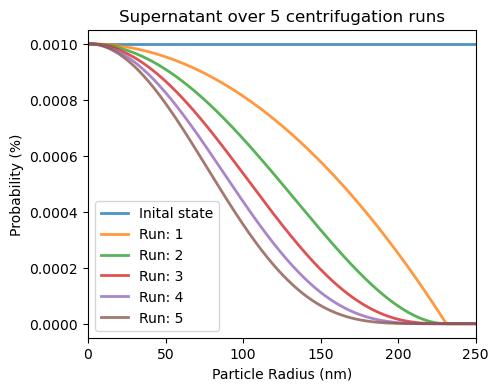

In [210]:
# How does the distribution of the particles over multiple runs change.
runs = 5
count = 1000
size = np.linspace(1,251,count) * 1e-9
rpm = 4000

# normalised to have all size equally likly
prob = np.ones(count) / count
times = 10


fig, ax = plt.subplots(figsize=(5,4))

ax.plot(size*1e9, prob, label=f"Inital state", alpha = 0.8, linewidth=2)

 
for j in range(runs):

    for i in range(count):
        prob[i], pallets = cal_supernate_and_pallets(size[i], prob[i], times,
                                              particle_density, liquid_density, liquid_viscosity,
                                             rpm, arm_length, length)
        
    ax.plot(size*1e9, prob, label=f"Run: {j+ 1}", alpha = 0.8, linewidth=2)

    
ax.set_xlim([0,250])
# ax.set_ylim([0,1.1])

ax.set_xlabel("Particle Radius (nm)")
ax.set_ylabel("Probability (%)")
ax.set_title(f"Supernatant over {runs} centrifugation runs")
ax.legend()


---

### Testing the behavour of the model - Non-uniformed Distribution

Before comparing the model to experimental results, it's essential to observe the behavior of the model when using a gamma distribution.

The gamma distribution is supported in the literature as being more appropriate than a Gaussian distribution for modeling the size distribution produced by Pulsed Laser Ablation in Liquids (PLAL). The gamma distribution, when normalized, represents the contribution of each particle size to the overall size distribution.

It's well-established that the size distribution in colloids is not uniform. Instead, literature suggests that it follows a gamma distribution. While it would be ideal to evolve the simulation to use a measured distribution in the future, starting with the gamma distribution is a solid initial approach.

The Composition (%) in this context indicates how much of the overall colloid contains a specific size of particle.

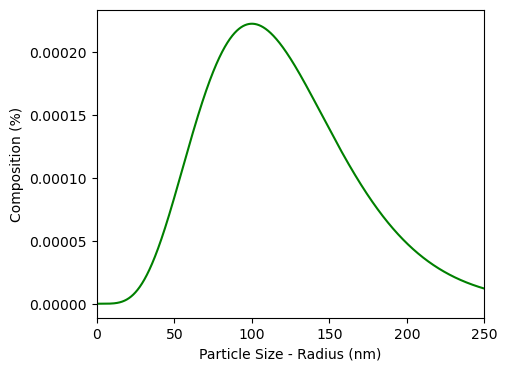

In [207]:
# Inital size distribution - gamma distribution
count = 10000
size = np.linspace(1,251,count) * 1e-9

shape_param = 6.0  # shape parameter (k)
scale_param = 20.0  # scale parameter (theta)

probability = gamma.pdf(size * 1e9, shape_param, scale=scale_param)

# Normalize the probability
probability /= np.sum(probability)

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(size*1e9, probability, color='Green')

ax.set_xlim([0,250])
# ax.set_ylim([0,1.1])

ax.set_xlabel("Particle Size - Radius (nm)")
ax.set_ylabel("Composition (%)")

plt.show(fig)

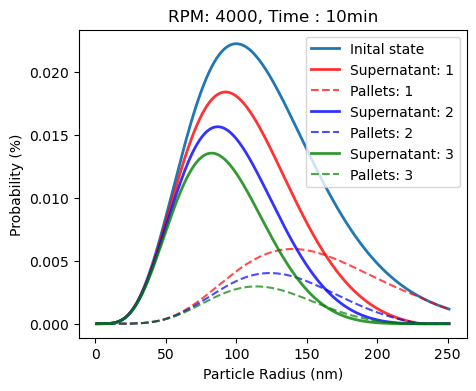

In [213]:
# How does the distribution supernate and pallets of the particles over multiple runs change.
runs = 3
# count = 1000
# size = np.linspace(1,251,count) * 1e-9

# Inital size distribution - uniformed distribution
count = 10000
size = np.linspace(1,251,count) * 1e-9

shape_param = 6.0  # shape parameter (k)
scale_param = 20.0  # scale parameter (theta)

probability = gamma.pdf(size * 1e9, shape_param, scale=scale_param)

# Normalize the probability
probability /= np.sum(probability)
rpm = 4000

prob = probability
pallets = np.zeros(count)
times = 10


# Define a color cycle for different runs
colors = ['red', 'blue', 'green']

fig, ax = plt.subplots(figsize=(5,4))

ax.plot(size*1e9, prob * 1e2, label=f"Inital state", linewidth=2)

 
for j in range(runs):

    for i in range(count):
        prob[i], pallets[i] = cal_supernate_and_pallets(size[i], prob[i], times,
                                              particle_density, liquid_density, liquid_viscosity,
                                             rpm, arm_length, length)
        
        
    ax.plot(size*1e9, prob * 1e2, label=f"Supernatant: {j +1}", alpha = 0.8, linewidth=2, color=colors[j]) 
    ax.plot(size*1e9, pallets * 1e2, label=f"Pallets: {j + 1}", alpha=0.7, linestyle='--', color=colors[j])


ax.set_xlabel("Particle Radius (nm)")
ax.set_ylabel("Probability (%)")
ax.set_title(f"RPM: {rpm}, Time : {times}min")
ax.legend()


### Importing and Validating the Data - Before Model Comparison

The data from the 2023 centrifugation experiments has been recorded and will be used to compare with the results from the model detailed above.

One of the challenges with this dataset (and centrifugation data for that fact,) is that each cycle's samples are collected from the supernatant of the previous run. This means that the data represents the composition (%) of the portion collected after each centrifugation cycle. Understanding this context is crucial for interpreting the results accurately.

As part of the data import process, it's essential to validate that the data is consistent with our expectations. A key characteristic to check is whether the composition percentages for each cycle sum to one (100%). If they do not, it could indicate an error in the data. For example, the data labeled "run 1 - 2kp" (which represents the size compositions of the pellets collected after the 2k RPM cycle) should sum to one. If it doesn't, this could suggest that particles outside the specified radii range (5-150 nm) are present but not captured in the dataset, or that the data is incomplete.

It's also worth noting that the data might have been artificially normalized beforehand, which is something we need to account for. However, this should not pose any issues because even if the data series do not initially sum to one, they can be normalized. Our focus is on the change in composition over the radii range (5-150 nm), so the exact sum is less critical than the relative differences.

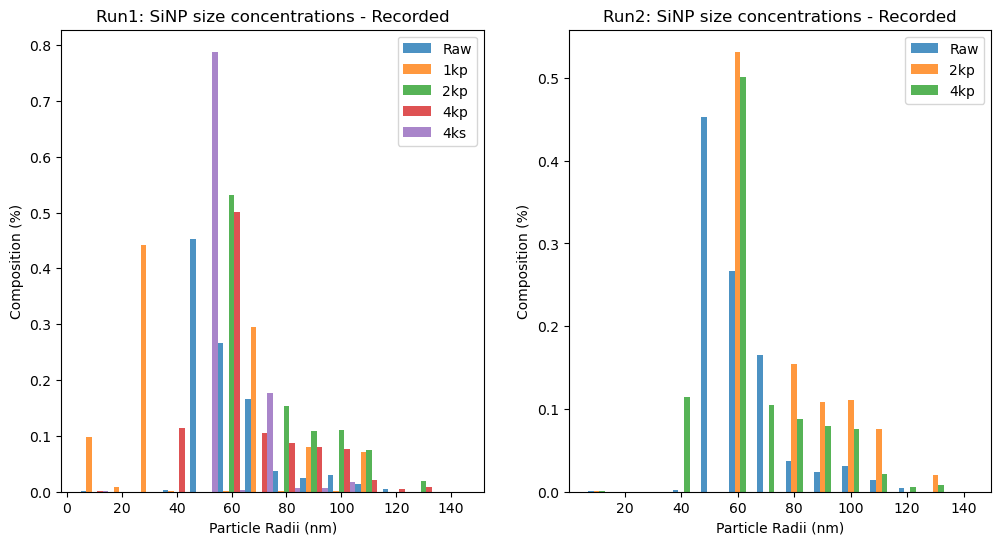

In [191]:
# how does the experimental data look?
# data = load_data_from_txt('/Users/william/Developer/Nano-Particle-Playground/data/Centrifugation/Week 5 - Data/concentrations - week 5.txt')
data = load_data_from_excel('/Users/william/Developer/Nano-Particle-Playground/data/Centrifugation/centrifugation_2023.xlsx', load_all_sheets=True)
run1 = data['run1']
run2 = data['run2']

# Plotting the data to see what the change in composition looks like over time
fig = plot_centrifuge_data(run1, run2, mask_limit=0, bar_width = 2)

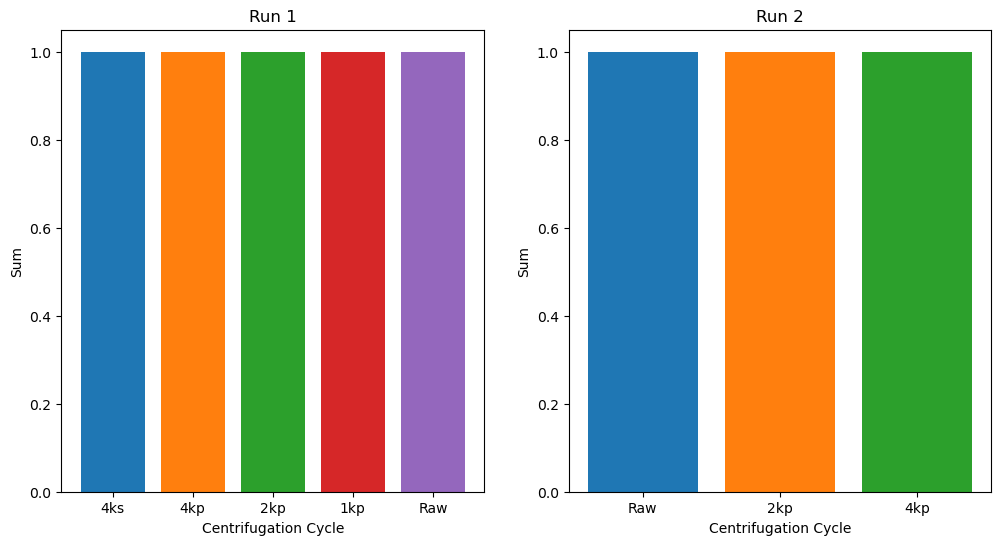

In [195]:
# Checking to see if all the values add up to one.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for run 1
ax1.set_title("Run 1")
ax1.set_xlabel('Centrifugation Cycle')
ax1.set_ylabel("Sum")
for ii in run1.columns:
    if ii != 'Radii(nm)':
        ax1.bar(ii, sum(run1[ii]))

# plot for run 2
ax2.set_title("Run 2")
ax2.set_xlabel('Centrifugation Cycle')  
ax2.set_ylabel("Sum")

for ii in run2.columns:  
    if ii != 'Radii(nm)':
        ax2.bar(ii, sum(run2[ii]))

In the above plots, we can see that for both Run 1 and Run 2, each centrifugation cycle sums to one. This matches our expectations for the data, confirming that the data is consistent and that each cycle's composition percentages are properly normalized. Since the data already sums to one, there is no need to perform additional normalization, allowing us to proceed directly with the model comparison and analysis.

### Questions about the data...
*What are the units for the recorded concentration?*
- The concentrations or percent compositions are normalised, the concentration units are particles per molar. but goven these are composition (%) each run can not be compared directly to each run.

*What is the duration of the centrifugation events?*
- I am going to assume that centrifugation was on a 10 min duration

*Is each recording from the samme Raw sample?*
- No, each sample is taken from the supernate of the previous cycle.

*Is 2kp initally taken from Raw or 1kp?*
- Assuming that Raw is the inital state for each of the centrifugation runs --> meaning that each recording is operated in a single centrifugation cycle

#### Centrifugation sample paths
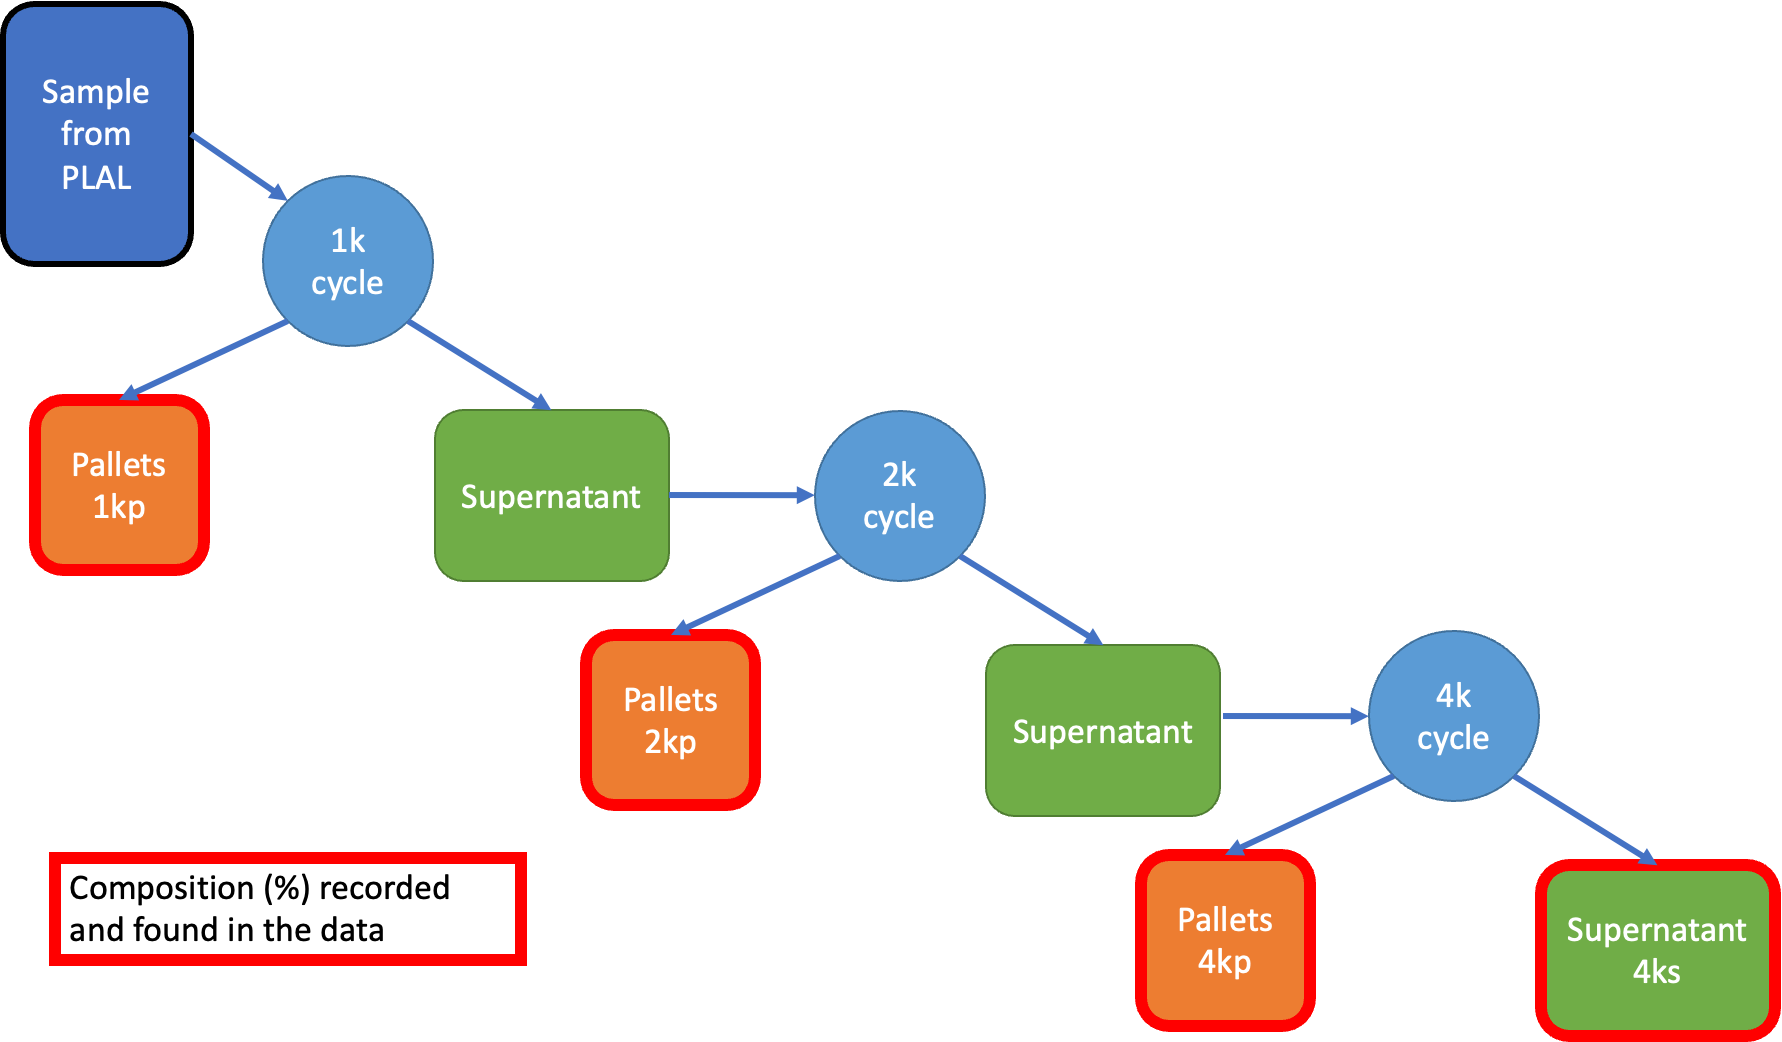

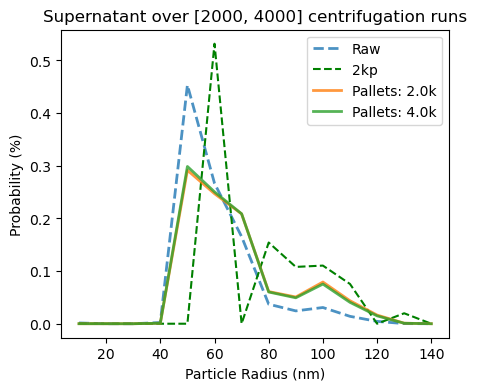

In [185]:
# How does the recorded size distribution change over time compared to the model?
mask = run2['Radii(nm)'] > 0

runs = [2000, 4000]
count = len(run2['Radii(nm)'][mask])
size = run2['Radii(nm)'][mask].to_numpy() * 1e-9

prob = run2['Raw'][mask].to_numpy()
times = 20

pallets = np.zeros(count)

fig, ax = plt.subplots(figsize=(5,4))

ax.plot(size*1e9, prob, label=f"Raw", alpha = 0.8, linewidth=2, linestyle='--')
ax.plot(size*1e9, run2['2kp'][mask].to_numpy(), color = 'green', label='2kp', linestyle='--')

 
for RPM in runs:

    for i in range(count):
        prob[i], pallets[i] = cal_supernate_and_pallets(size[i], prob[i], times,
                                              particle_density, liquid_density, liquid_viscosity,
                                             RPM, arm_length, length) # add pecent change to the model's output log
        
    pallets = pallets / np.sum(pallets)
    prob = prob / np.sum(prob)
    ax.plot(size*1e9, pallets, label=f"Pallets: {RPM/1000}k", alpha = 0.8, linewidth=2)
    ax.plot(size*1e9, prob, label=f"Supernate: {RPM/1000}k", alpha = 0.8, linewidth=2, linestyle='-.')
    

    
# ax.set_xlim([0,250])
# ax.set_ylim([0,1.1])

ax.set_xlabel("Particle Radius (nm)")
ax.set_ylabel("Probability (%)")
ax.set_title(f"Supernatant over {runs} centrifugation runs")
ax.legend()

2.1331745344399478

In [19]:
# normalsing the concentration
data = normalize_data(data)
data

,Radii(nm),Raw,1kp,2kp,4kp,8kp,8ks,Raw_norm,1kp_norm,2kp_norm,4kp_norm,8kp_norm,8ks_norm
0,1.0,7.685676e+14,6.483145e+14,3.798114e+14,1.518078e+14,2.865572e+14,2.781941e+14,1.000000e+00,9.391830e-01,1.000000,1.000000e+00,1.000000,1.000000e+00
1,2.0,4.817059e+14,6.839448e+14,1.784217e+14,3.944614e+12,2.005333e+14,2.300023e+13,6.267580e-01,9.907990e-01,0.469764,2.598426e-02,0.699802,8.267691e-02
2,3.0,9.442403e+10,6.902962e+14,2.038721e+13,6.167869e+10,8.443178e+13,4.811114e+11,1.228391e-04,1.000000e+00,0.053677,4.062896e-04,0.294642,1.729400e-03
3,4.0,4.101071e+12,5.776151e+14,1.221806e+13,2.562836e+10,1.045829e+13,2.139849e+11,5.335975e-03,8.367641e-01,0.032169,1.688160e-04,0.036496,7.691838e-04
4,5.0,1.219889e+12,1.692603e+14,1.653221e+12,1.286898e+10,4.962216e+12,1.082024e+11,1.587206e-03,2.451995e-01,0.004353,8.476645e-05,0.017316,3.889364e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,171.0,2.923032e+08,5.484072e+08,7.201171e+08,1.879710e+06,4.339638e+10,2.449949e+08,3.622354e-07,7.770553e-07,0.000002,7.307225e-09,0.000151,8.715479e-07
171,172.0,1.973226e+08,2.623644e+08,6.733855e+08,1.797007e+06,2.075196e+10,1.550361e+08,2.386542e-07,3.626784e-07,0.000002,6.762436e-09,0.000072,5.481812e-07
172,173.0,1.414667e+08,1.829645e+08,6.259766e+08,1.413597e+06,1.268511e+09,9.916970e+07,1.659789e-07,2.476554e-07,0.000002,4.236808e-09,0.000004,3.473630e-07
173,174.0,1.493765e+08,2.038264e+08,7.539985e+08,1.037768e+06,1.036834e+09,1.260301e+08,1.762705e-07,2.778771e-07,0.000002,1.761120e-09,0.000003,4.439159e-07


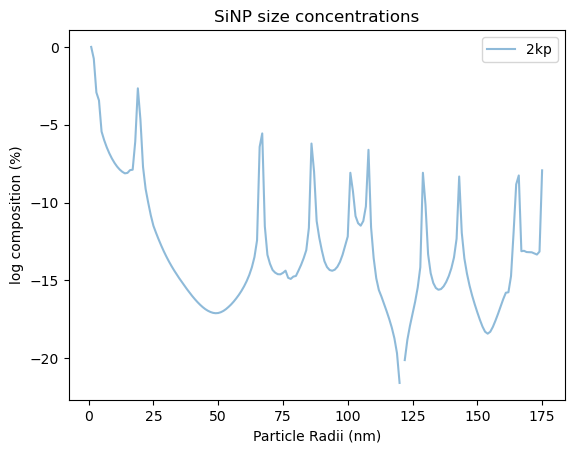

In [39]:
mask = data['Radii(nm)'] > 0
# plt.plot(data['Radii(nm)'][mask], np.log(data['Raw_norm'][mask]), label='Raw', alpha = 1)
# plt.plot(data['Radii(nm)'][mask], np.log(data['1kp_norm'][mask]), label='1kp', alpha = 0.5)
plt.plot(data['Radii(nm)'][mask], np.log(data['2kp_norm'][mask]), label='2kp', alpha = 0.5)

# plt.plot(data['Radii(nm)'][mask], data['Raw_norm'][mask], label='Raw', alpha = 0.5)
# plt.plot(data['Radii(nm)'][mask], data['1kp_norm'][mask], label='1kp', alpha = 0.5)
# plt.plot(data['Radii(nm)'][mask], data['2kp_norm'][mask], label='2kp', alpha = 0.5)
# plt.plot(data['Radii(nm)'][mask], np.log(data['4kp'][mask]), label='4kp', alpha = 0.5)
# plt.plot(data['Radii(nm)'][mask], np.log(data['8kp'][mask]), label='8kp', alpha = 0.5)
# plt.plot(data['Radii(nm)'][mask], np.log(data['8ks'][mask]), label='8ks', alpha = 0.5)

plt.title("SiNP size concentrations")
plt.ylabel("log composition (%)")
plt.xlabel("Particle Radii (nm)")
plt.legend()

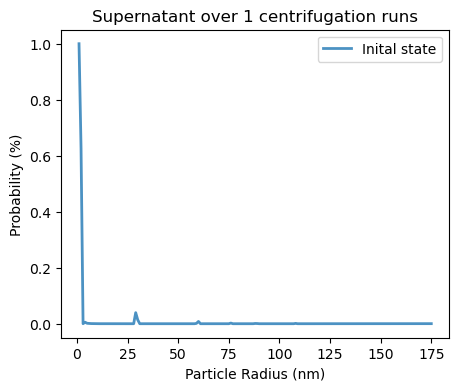

In [31]:
# How does the distribution of the particles over multiple runs change.
runs = 1
size = data['Radii(nm)']
rpm = 1000
prob = data['Raw_norm']
times = 10 # duration of centrifugation
count = len(size)


fig, ax = plt.subplots(figsize=(5,4))

ax.plot(size, prob, label=f"Inital state", alpha = 0.8, linewidth=2)

 
for j in range(runs):

    for i in range(count):
        prob[i], pallets = cal_supernate_and_pallets(size[i], prob[i], times,
                                              particle_density, liquid_density, liquid_viscosity,
                                             rpm, arm_length, length)
        
#     ax.plot(size, prob, label=f"Run: {j+ 1}", alpha = 0.8, linewidth=2)

    
# ax.set_xlim([0,250])
# ax.set_ylim([0,1.1])

ax.set_xlabel("Particle Radius (nm)")
ax.set_ylabel("Probability (%)")
ax.set_title(f"Supernatant over {runs} centrifugation runs")
ax.legend()

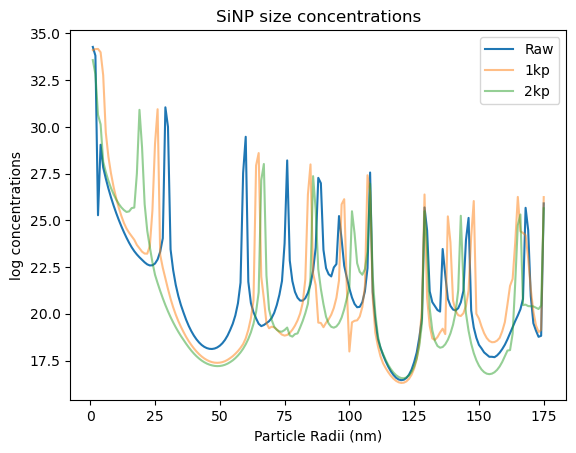

In [9]:
mask = run1['Radii(nm)'] > 0
plt.plot(run1['Radii(nm)'][mask], np.log(['Raw'][mask]), label='Raw', alpha = 1)
plt.plot(data['Radii(nm)'][mask], np.log(data['1kp'][mask]), label='1kp', alpha = 0.5)
plt.plot(data['Radii(nm)'][mask], np.log(data['2kp'][mask]), label='2kp', alpha = 0.5)

# plt.plot(data['Radii(nm)'][mask], np.log(data['8kp'][mask]), label='8kp', alpha = 0.5)
# plt.plot(data['Radii(nm)'][mask], np.log(data['8ks'][mask]), label='8ks', alpha = 0.5)

plt.title("SiNP size concentrations")
plt.ylabel("log concentrations")
plt.xlabel("Particle Radii (nm)")
plt.legend()